In [1]:
import json, os
import cv2
import torch
from multiprocessing import Pool, Manager
from aquabyte.data_access_utils import S3AccessUtils, RDSAccessUtils
from aquabyte.akpd import AKPD
from aquabyte.template_matching import find_matches_and_homography
from aquabyte.biomass_estimator import NormalizeCentered2D, NormalizedStabilityTransform, ToTensor, Network
from aquabyte.data_loader import KeypointsDataset, NormalizeCentered2D, ToTensor, BODY_PARTS
from torch.utils.data import Dataset, DataLoader
from aquabyte.optics import euclidean_distance, pixel2world, depth_from_disp, convert_to_world_point

from aquabyte.akpd_scorer import generate_confidence_score
from keras.models import load_model
import boto3
import pandas as pd
import numpy as np
import plotly.express as px
import time
from matplotlib import pyplot as plt

from collections import defaultdict
import datetime as dt
import json
import numpy as np
from sklearn.linear_model import LinearRegression
from collections import defaultdict



Using TensorFlow backend.


In [2]:
from collections import defaultdict
import json
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression

# compute daily growth rate via fitting an exponential curve,
# weighting each day by its sample size
def compute_growth_rate(tdf, rdf, start_date, end_date):
    x_values = [(dt.datetime.strptime(k, '%Y-%m-%d') - \
                 dt.datetime.strptime(start_date, '%Y-%m-%d')).days \
                 for k in tdf.index.date.astype(str)]
    X = np.array(x_values).reshape(-1, 1)
    y = np.log(tdf.values)
    reg = LinearRegression().fit(X, y, sample_weight=rdf.values)
    growth_rate = reg.coef_[0]
    trend_score = reg.score(X, y, sample_weight=rdf.values)
    return growth_rate, trend_score


# compute distribution confidence via looking at RMS of percent deviations for qq plot
# of today's distribution against distribution in the remainder of the window
def compute_distribution_confidence(df, start_date, end_date, date):
    mean_adjustment = df[date:date].estimated_weight_g.mean() - df[start_date:end_date].estimated_weight_g.mean()
    x = np.percentile(df[start_date:end_date].estimated_weight_g + mean_adjustment, list(range(100)))
    y = np.percentile(df[date:date].estimated_weight_g, list(range(100)))
    distribution_confidence = np.mean(np.square((x[1:99] - y[1:99]) / y[1:99])) ** 0.5
    return distribution_confidence


# NOTE: we need to think more carefully about this to understand how distribution 
# confidence and trend score affect the minimum sample size we want. Hardcoded for now. 
def compute_minimum_sample_size(distribution_confidence, trend_score):
    return 5000
    
# Smart average is defined as a lookback to a maximum of window_size_d days (currently set to 7),
# or until the minimum sample size is achieved
def compute_smart_average(df, tdf, rdf, date, distribution_confidence, growth_rate, 
                          trend_score, window_size_d, bucket_size=0.1):
    
    dates = sorted(list(tdf.index.date.astype(str)))
    if len(dates) == 1:
        growth_rate = 0.0
    minimum_sample_size = compute_minimum_sample_size(distribution_confidence, trend_score)
    x_values = [(dt.datetime.strptime(date, '%Y-%m-%d') - \
                 dt.datetime.strptime(k, '%Y-%m-%d')).days \
                 for k in tdf.index.date.astype(str)]
    X = np.array(x_values).reshape(-1, 1)
    Y = tdf.values
    N = rdf.values
    
    for i in range(window_size_d):
        if N[np.abs(np.squeeze(X)) <= i].sum() >= minimum_sample_size:
            break
    N[np.abs(np.squeeze(X)) > i] = 0
    
    smart_average = 0.0
    sample_size = 0.0
    adj_weights = []
    total_days = 0
    for x, y, n, this_date in zip(X, Y, N, dates):
        smart_average += np.exp(x * growth_rate) * y * n
        sample_size += n
        if n > 0:
            adj_weights_for_date = \
                list(np.exp(x * growth_rate) * df[this_date:this_date].estimated_weight_g.values)
            adj_weights.extend(adj_weights_for_date)
            total_days += 1
        
    smart_average /= sample_size
    
    adj_weights = np.array(adj_weights)
    distribution = {}
    buckets = [round(x, 1) for x in np.arange(0.0, 1e-3 * adj_weights.max(), bucket_size)]
    for b in buckets:
        low, high = 1e3 * b, 1e3 * (b + bucket_size)
        count = adj_weights[(adj_weights >= low) & (adj_weights < high)].shape[0]
        distribution[b] = count / sample_size
    
    output = {
        'weightMovingAvg': float(smart_average),
        'weightMovingDist': distribution,
        'numMovingAvgBatiFish': sample_size,
        'numMovingAvgLookbackDays': total_days,
        'dailyGrowthRate': growth_rate
    }
    
    return output


# generate date range given current date and window size. If future data
# is available relative to current date, windows where the current date
# is centered are preferred
def compute_date_range(historical_dates, date, window_size_d):
    FMT = '%Y-%m-%d'
    max_num_days = 0
    start_date, end_date = None, None
    for i in range(window_size_d // 2 + 1):
        lower_bound_date = (dt.datetime.strptime(date, FMT) - dt.timedelta(days=window_size_d-1) + \
                            dt.timedelta(days=i)).strftime(FMT)
        upper_bound_date = (dt.datetime.strptime(date, FMT) + dt.timedelta(days=i)).strftime(FMT)
        num_days = ((np.array(historical_dates)  >= lower_bound_date) & \
                    (np.array(historical_dates) <= upper_bound_date)).sum()
        if num_days >= max_num_days:
            start_date, end_date = lower_bound_date, upper_bound_date
            max_num_days = num_days
    
    return start_date, end_date


def compute_metrics(date, records_json, window_size_d=7):
    
    records = json.loads(records_json)
    
    dts, vals = [], []
    for iter_date in records:
        for val in records[iter_date]:
            dts.append(iter_date)
            vals.append(val)

    df = pd.DataFrame(vals, index=pd.to_datetime(dts), columns=['estimated_weight_g'])
    
    # get raw statistics
    raw_avg_weight = df[date:date].estimated_weight_g.mean()
    raw_sample_size = df[date:date].shape[0]
    
    # compute relevant date range
    historical_dates = sorted(list(set(df.index.date.astype(str))))
    start_date, end_date = compute_date_range(historical_dates, date, window_size_d)
    rdf = df[start_date:end_date].estimated_weight_g.resample('D').agg(lambda x: x.shape[0])
    tdf = df[start_date:end_date].estimated_weight_g.resample('D').agg(lambda x: x.mean())
    tdf = tdf[rdf > 0].copy(deep=True)
    rdf = rdf[rdf > 0].copy(deep=True)
    
    growth_rate, trend_score, distribution_confidence = None, None, None
    if start_date < end_date:
        growth_rate, trend_score = compute_growth_rate(tdf, rdf, start_date, end_date)
        distribution_confidence = compute_distribution_confidence(df, start_date, end_date, date)
    smart_average = compute_smart_average(df, tdf, rdf, date, 
                                          distribution_confidence, growth_rate, 
                                          trend_score, window_size_d)
    metadata = {
        'trend_score': trend_score,
        'distribution_confidence': distribution_confidence
    }

    return raw_avg_weight, raw_sample_size, smart_average, metadata

In [3]:
# extract dataframe
s3_access_utils = S3AccessUtils('/root/data')
rds_access_utils = RDSAccessUtils(json.load(open(os.environ['DATA_WAREHOUSE_SQL_CREDENTIALS'])))

pen_id, group_id = 88, '88'
query = """
    SELECT * FROM
    prod.biomass_computations bc
    WHERE bc.pen_id={0}
    AND bc.group_id='{1}'
    AND bc.akpd_score > 0.9;
""".format(pen_id, group_id)

# query = """
#     SELECT * FROM (
#       (SELECT * FROM prod.crop_annotation cas
#       INNER JOIN prod.annotation_state pas on pas.id=cas.annotation_state_id
#       WHERE cas.service_id = (SELECT ID FROM prod.service where name='BATI')
#       AND cas.annotation_state_id = 3
#       AND cas.pen_id=88) a
#     RIGHT JOIN 
#       (SELECT left_crop_url, estimated_weight_g, akpd_score FROM prod.biomass_computations
#       WHERE prod.biomass_computations.captured_at between '2020-02-10' and '2020-02-29'
#       AND prod.biomass_computations.akpd_score > 0.9) bc 
#     ON 
#       (a.left_crop_url=bc.left_crop_url)
#     ) x
#     WHERE x.captured_at between '2020-02-10' and '2020-02-29'
#     AND x.pen_id = 88
#     AND x.group_id = '88';
# """

df = rds_access_utils.extract_from_database(query)
df = df.sort_values('captured_at')
df = df[df.akpd_score > 0.9].copy(deep=True)
df.index = pd.to_datetime(df.captured_at)
df['hour'] = df.index.hour


In [4]:
day_mask = (df.hour > 7) & (df.hour < 16)
# low_kf_mask = df.k_factor < 1.0
tdf = df[day_mask]

# get daily averages and sample sizes

records = defaultdict(list)
for date in sorted(list(set(tdf.index.date.astype(str)))):
    records[date].extend(tdf[date].estimated_weight_g.values.tolist())

records_json = json.dumps(records)

dates = sorted(list(set(tdf.index.date.astype(str))))
raw_avg_weights, raw_sample_sizes, growth_rates, trend_scores, smart_averages, distribution_confidences = [], [], [], [], [], []
for date in dates:
    raw_avg_weight, raw_sample_size, smart_average, metadata = compute_metrics(date, records_json)
    growth_rates.append(smart_average['dailyGrowthRate'])
    trend_scores.append(metadata['trend_score'])
    raw_avg_weights.append(raw_avg_weight)
    raw_sample_sizes.append(raw_sample_size)
    smart_averages.append(smart_average['weightMovingAvg'])
    distribution_confidences.append(metadata['distribution_confidence'])


/home/user/miniconda/envs/py36/lib/python3.6/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning:

Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


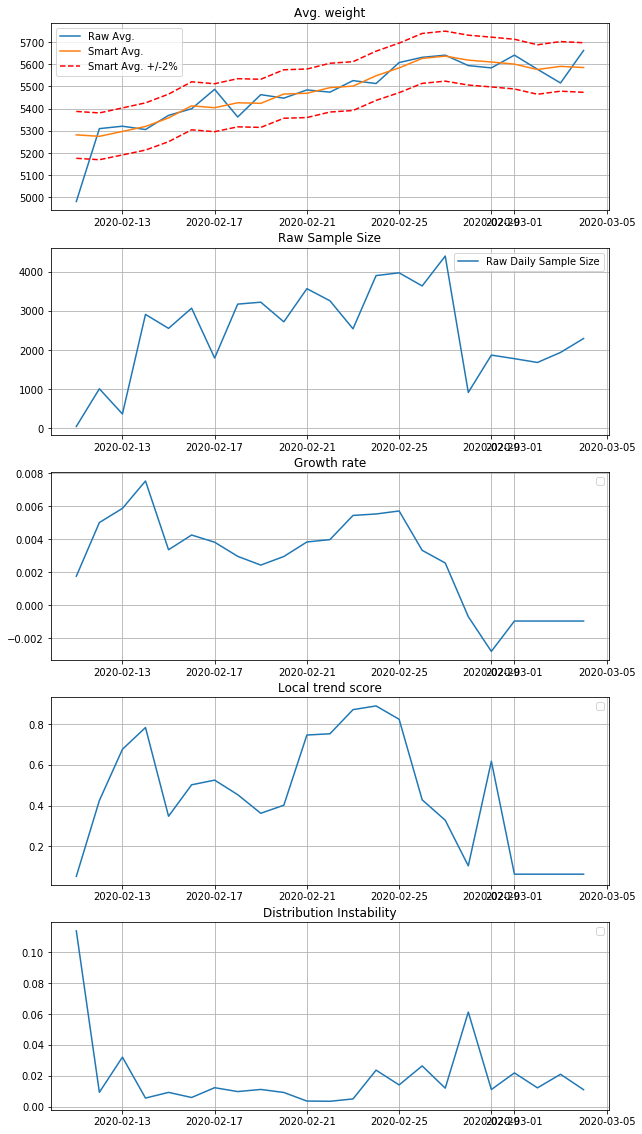

In [5]:
fig, axes = plt.subplots(5, 1, figsize=(10, 20))
x_values = tdf.estimated_weight_g.resample('D').agg(lambda x: x.mean()).dropna().index
axes[0].plot(x_values, raw_avg_weights, label='Raw Avg.')
axes[0].plot(x_values, smart_averages, label='Smart Avg.')
axes[0].plot(x_values, 1.02 * np.array(smart_averages), color='red', linestyle='--', label='Smart Avg. +/-2%')
axes[0].plot(x_values, 0.98 * np.array(smart_averages), color='red', linestyle='--')
axes[1].plot(x_values, raw_sample_sizes, label='Raw Daily Sample Size')
axes[2].plot(x_values, growth_rates)
axes[3].plot(x_values, trend_scores)
axes[4].plot(x_values, distribution_confidences)
for i, title in zip([0, 1, 2, 3, 4], ['Avg. weight', 'Raw Sample Size', 'Growth rate', 'Local trend score', 'Distribution Instability']):
    axes[i].set_title(title)
    axes[i].grid()
    axes[i].legend()
plt.show()

In [ ]:
growth_rates, trend_scores, raw_avg_weights, raw_sample_sizes, smart_averages = \
defaultdict(list), defaultdict(list), defaultdict(list), defaultdict(list), defaultdict(list)
for lo in [6, 7, 8]:
    for hi in [14, 15, 16, 17]:
        key = '{}-{}'.format(lo, hi)
        print(key)
        day_mask = (df.hour > lo) & (df.hour < hi)
        tdf = df[day_mask]

        # get daily averages and sample sizes

        records = defaultdict(list)
        for date in sorted(list(set(tdf.index.date.astype(str)))):
            records[date].extend(tdf[date].estimated_weight_g.values.tolist())

        records_json = json.dumps(records)

        dates = sorted(list(set(tdf.index.date.astype(str))))
        for date in dates:
            raw_avg_weight, raw_sample_size, smart_average, metadata = compute_metrics(date, records_json)
            growth_rates[key].append(smart_average['dailyGrowthRate'])
            trend_scores[key].append(metadata['trend_score'])
            raw_avg_weights[key].append(raw_avg_weight)
            raw_sample_sizes[key].append(raw_sample_size)
            smart_averages[key].append(smart_average['weightMovingAvg'])


In [ ]:
import plotly.graph_objects as go

In [ ]:
fig = go.Figure()
for lo in [6, 7, 8]:
    for hi in [14, 15, 16, 17]:
        key = '{}-{}'.format(lo, hi)
        fig.add_trace(go.Scatter(x=x_values[1:], y=smart_averages[key][1:],
                            mode='lines',
                            name=key))


fig.show()

In [58]:
mdf = pd.DataFrame(smart_averages, index=x_values).round(2)
mdf['max_variation_pct'] = (mdf.max(axis=1) - mdf.min(axis=1)) / mdf.mean(axis=1)

In [59]:
mdf

,6-14,6-15,6-16,6-17,7-14,7-15,7-16,7-17,8-14,8-15,8-16,8-17,max_variation_pct
captured_at,,,,,,,,,,,,,
2020-02-11 00:00:00+00:00,5237.09,5260.18,5253.88,5207.08,5275.94,5293.18,5281.95,5228.54,5262.24,5283.55,5272.57,5218.27,0.016381
2020-02-12 00:00:00+00:00,5237.96,5249.35,5265.83,5237.74,5248.67,5258.96,5275.37,5244.62,5261.83,5271.05,5287.93,5252.55,0.009546
2020-02-13 00:00:00+00:00,5307.52,5297.28,5300.47,5279.71,5303.26,5293.17,5297.37,5275.65,5290.35,5284.99,5291.66,5267.50,0.007564
2020-02-14 00:00:00+00:00,5325.10,5316.12,5326.47,5312.79,5304.50,5308.06,5319.79,5305.53,5289.68,5293.13,5318.64,5290.70,0.006929
2020-02-15 00:00:00+00:00,5331.87,5337.13,5358.14,5349.27,5330.78,5336.27,5358.37,5349.10,5313.48,5322.13,5348.62,5338.58,0.008407
2020-02-16 00:00:00+00:00,5380.17,5395.37,5405.36,5400.75,5388.92,5403.01,5412.82,5407.93,5366.38,5385.48,5397.67,5392.54,0.008608
2020-02-17 00:00:00+00:00,5358.96,5377.80,5391.72,5390.51,5373.66,5390.74,5404.36,5402.87,5375.48,5394.02,5408.42,5406.55,0.009177
2020-02-18 00:00:00+00:00,5413.78,5420.10,5419.48,5421.57,5421.96,5427.71,5426.64,5428.61,5432.24,5437.52,5435.62,5437.43,0.004375
2020-02-19 00:00:00+00:00,5429.59,5428.47,5419.73,5399.76,5435.51,5433.73,5424.04,5402.64,5449.36,5445.69,5433.54,5408.83,0.009141


In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(12, 8))
axes[0].plot(x_values[1:], smart_averages, label='Smart Avg.')
axes[0].set_title('Growth trend for fish with KF > 1')
axes[0].grid()

axes[1].plot(x_values, smart_averages_2, label='Smart Avg. 2')
axes[1].set_title('Growth trend for fish with KF < 1')
axes[1].grid()
# axes[1].set_ylim([1400, 1700])

plt.show()


In [ ]:
np.log(smart_averages[-1] / smart_averages[0]) / len(smart_averages)

In [ ]:
np.log(smart_averages_2[-1] / smart_averages_2[0]) / len(smart_averages_2)

In [ ]:
growth_rates[-1]

In [ ]:
day_mask = (df.hour > 7) & (df.hour < 16)
low_kf_mask = df.k_factor < 1.0
tdf = df[~day_mask & low_kf_mask]

# get daily averages and sample sizes

records = defaultdict(list)
for date in sorted(list(set(tdf.index.date.astype(str)))):
    records[date].extend(tdf[date].estimated_weight_g.values.tolist())

records_json = json.dumps(records)

dates = sorted(list(set(tdf.index.date.astype(str))))
raw_avg_weights, raw_sample_sizes, growth_rates, trend_scores, smart_averages_2, distribution_confidences = [], [], [], [], [], []
for date in dates:
    raw_avg_weight, raw_sample_size, smart_average, metadata = compute_metrics(date, records_json)
    growth_rates.append(smart_average['dailyGrowthRate'])
    trend_scores.append(metadata['trend_score'])
    raw_avg_weights.append(raw_avg_weight)
    raw_sample_sizes.append(raw_sample_size)
    smart_averages_2.append(smart_average['weightMovingAvg'])
    distribution_confidences.append(metadata['distribution_confidence'])


In [ ]:
fig, axes = plt.subplots(5, 1, figsize=(10, 20))
x_values = tdf.estimated_weight_g.resample('D').agg(lambda x: x.mean()).dropna().index
axes[0].plot(x_values, raw_avg_weights, label='Raw Avg.')
axes[0].plot(x_values, smart_averages, label='Smart Avg.')
axes[0].plot(x_values, 1.02 * np.array(smart_averages), color='red', linestyle='--', label='Smart Avg. +/-2%')
axes[0].plot(x_values, 0.98 * np.array(smart_averages), color='red', linestyle='--')
axes[1].plot(x_values, raw_sample_sizes, label='Raw Daily Sample Size')
axes[2].plot(x_values, growth_rates)
axes[3].plot(x_values, trend_scores)
axes[4].plot(x_values, distribution_confidences)
for i, title in zip([0, 1, 2, 3, 4], ['Avg. weight', 'Raw Sample Size', 'Growth rate', 'Local trend score', 'Distribution Instability']):
    axes[i].set_title(title)
    axes[i].grid()
    axes[i].legend()
plt.show()

In [ ]:
plt.figure(figsize=(10, 5))
hour_mask = (df.hour > 7) & (df.hour < 19)
plt.hist(df[~hour_mask & (df.captured_at > '2020-02-16') & (df.captured_at < '2020-02-17')].estimated_weight_g, bins=20)
plt.title('Aggregate Weight Distribution (24 hour data)')
plt.xlabel('Weight Prediction')
plt.ylabel('Count')
plt.show()

In [ ]:
plt.figure(figsize=(10, 5))
plt.hist(df.estimated_weight_g, bins=50)
plt.title('Aggregate Weight Distribution (Daylight hours only)')
plt.xlabel('Weight Prediction')
plt.ylabel('Count')
plt.show()

In [ ]:
dates = sorted(list(set(df.index.date.astype(str))))
N = 2
for idx in range(len(dates)-N-1):
    start_date, end_date, date = dates[idx], dates[idx+N], dates[idx+N+1]
    mean_adjustment = df[date].estimated_weight_g.mean() - df[start_date:end_date].estimated_weight_g.mean()
    x = np.percentile(df[start_date:end_date].estimated_weight_g + mean_adjustment, list(range(100)))
    y = np.percentile(df[date].estimated_weight_g, list(range(100)))
    fig, axes = plt.subplots(1, 2, figsize=(10, 3))
    axes[0].scatter(x[1:99], y[1:99])
    axes[0].plot([x[1], x[99]], [x[1], x[99]], color='red')
    axes[0].set_title(date)
    axes[0].grid()
    
    lower_bound = int(df[start_date:date].estimated_weight_g.min() * 0.8)
    upper_bound = int(df[start_date:date].estimated_weight_g.max() * 1.2)
    
    axes[1].hist(df[start_date:end_date].estimated_weight_g, bins=list(np.arange(lower_bound, upper_bound, 100)), color='blue', alpha=0.5, density=True)
    axes[1].hist(df[date].estimated_weight_g, bins=list(np.arange(lower_bound, upper_bound, 100)), color='red', alpha=0.5, density=True)
    axes[1].set_title(date)
    axes[1].grid()
    
    plt.show()

In [ ]:
dates = sorted(list(set(df.index.date.astype(str))))
cols = 3
rows = len(dates) // 3
fig, axes = plt.subplots(rows, cols, figsize=(12, 8))
fig.tight_layout(pad=3.0)
for idx, date in enumerate(dates):
    if idx == 8:
        continue
    tdf = df[date][df[date].estimated_weight_g > 3000].groupby('hour')['estimated_weight_g'].agg(lambda x: x.shape[0])
    
    row, col = idx // 3, idx % 3
    axes[row, col].plot(tdf.index, tdf.values)
    axes[row, col].set_xlabel('Hour')
    axes[row, col].set_ylabel('Avg. Weight')
    axes[row, col].set_title(date)
    
plt.show()
    

<h1> Add in Length / K-Factor Analysis </h1>

In [ ]:
class KeypointsDataset(Dataset):
    """Keypoints dataset
    This is the base version of the dataset that is used to map 3D keypoints to a
    biomass estimate. The label is the weight, and the input is the 3D workd keypoints
    obtained during triangulation
    """

    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform


    def __len__(self):
        return self.df.shape[0]


    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        if self.transform:
            input_sample = {
                'keypoints': row.keypoints,
                'cm': row.camera_metadata,
                'stereo_pair_id': row.id,
            }
            if 'length' in dict(row).keys():
                input_sample['label'] = row.length
            sample = self.transform(input_sample)
            return sample

        world_keypoints = row.world_keypoints
        length = row.length

        sample = {'kp_input': world_keypoints, 'label': length, 'stereo_pair_id': row.id}

        return sample
    
class NormalizedStabilityTransform(object):
    """
        Transforms world keypoints into a more stable coordinate system - this will lead to better
        training / convergene
    """
    
    def __call__(self, sample):
        modified_kps, label, stereo_pair_id, cm = \
            sample['modified_kps'], sample['label'], sample['stereo_pair_id'], sample['cm']
        modified_wkps = pixel2world(modified_kps['leftCrop'], modified_kps['rightCrop'], cm)
        stabilized_coordinates = {}
        for bp in BODY_PARTS:
            wkp = modified_wkps[bp]
            stabilized_kp_info = [0.5 * wkp[0]/wkp[1], 0.5 * wkp[2]/wkp[1], 0.5 * 0.1/wkp[1]]
            stabilized_coordinates[bp] = stabilized_kp_info
            
        normalized_label = label
        
        transformed_sample = {
            'kp_input': stabilized_coordinates,
            'label': normalized_label,
            'stereo_pair_id': stereo_pair_id,
            'single_point_inference': sample.get('single_point_inference')
        }
        
        return transformed_sample

In [ ]:
# TODO: Define your network architecture here
import torch
from torch import nn

class Network(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(24, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.output = nn.Linear(64, 1)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = x.view(x.shape[0], -1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = self.relu(x)
        x = self.output(x)
        return x
        



In [ ]:
network = torch.load('/root/data/alok/biomass_estimation/playground/length_predictor.pb')
normalize_centered_2D_transform = NormalizeCentered2D()
normalized_stability_transform = NormalizedStabilityTransform()
to_tensor_transform = ToTensor()

In [ ]:
def generate_length(row_id, akpd_keypoints, cm):

    # run length estimation
    input_sample = {
        'keypoints': akpd_keypoints,
        'cm': cm,
        'stereo_pair_id': row_id,
        'single_point_inference': True
    }
    nomralized_centered_2D_kps = \
        normalize_centered_2D_transform.__call__(input_sample)

    normalized_stability_kps = normalized_stability_transform.__call__(nomralized_centered_2D_kps)
    tensorized_kps = to_tensor_transform.__call__(normalized_stability_kps)
    length_prediction = network(tensorized_kps['kp_input']).item() * 1e-3
    
    return length_prediction


In [ ]:
lengths = []
args = []
count = 0
for idx, row in df.iterrows():
    cm = row.camera_metadata
    akpd_keypoints = row.annotation
    row_id = idx
    length = generate_length(row_id, akpd_keypoints, cm)
    lengths.append(length)
    
    if count % 100 == 0:
        print(count)
    count += 1

In [ ]:
df['length'] = lengths
df['k_factor'] = 1e5 * df.estimated_weight_g / (1e3 * df.length)**3

In [ ]:
plt.hist(df.k_factor, bins=20)
plt.show()

In [ ]:
df[df.k_factor > 2.5].shape[0] / df.shape[0]

In [ ]:
plt.scatter(df.estimated_weight_g, df.k_factor)
plt.show()

In [ ]:
weights = np.arange(500, 9000, 500)
mean_kfs = []
for idx in range(len(weights) - 1):
    lo, hi = weights[idx], weights[idx + 1]
    mask = (df.estimated_weight_g > lo) & (df.estimated_weight_g < hi)
    mean_kf = df[mask].k_factor.mean()
    mean_kfs.append(mean_kf)
    

In [ ]:
plt.figure(figsize=(10, 5))
x_pos = np.arange(len(weights[:-1]))
plt.bar(x_pos, mean_kfs, align='edge', width=0.9)
plt.xticks(x_pos, weights[:-1])
plt.title('K-Factor vs. Weight')
plt.xlabel('Predicted weight (g)')
plt.ylabel('Predicted K-factor')
plt.grid()
plt.show()

In [ ]:
tdf = df[df.k_factor < np.percentile(df.k_factor, 98)].copy(deep=True)

plt.figure(figsize=(20, 10))
start_date, end_date = '2020-02-19', '2020-02-20'
plt.scatter(tdf[start_date:end_date].index, 
            tdf[start_date:end_date].estimated_weight_g,
            c=tdf[start_date:end_date].k_factor, cmap='viridis')
plt.colorbar()
plt.grid()
plt.xlabel('Date')
plt.ylabel('Estimated Weight (g)')
plt.title('Weight Predictions vs. Time, color-coded by K-Factor')
plt.show()